In [1]:
# using CUDA
using DataFrames
using Flux
import JSON
using Lathe.preprocess: TrainTestSplit
using LinearAlgebra
using Plots
using StatsBase
using StatsPlots

include("../helpers.jl")
include("../stats.jl")

updatescoresdict! (generic function with 1 method)

## Getting data together

In [2]:
# get data
x_df = DataFrame(
    CORX=Float64[],
    CORY=Float64[],
    I0=Float64[],
    K1Q1=Float64[],
    K1Q2=Float64[],
    SIGT=Float64[],
    SIGX=Float64[],
    SIGY=Float64[]
)
y_df = DataFrame(
    DE=Float64[],
    EMIT_X=Float64[],
    EMIT_Y=Float64[],
    REF_Z=Float64[],
    RMS_S=Float64[],
    RMS_X=Float64[],
    RMS_Y=Float64[]
)

x_df, y_df = readjsonsfromdirectory("../data/fodo-data-varying-magnets", x_df, y_df);
select!(y_df, Not(:REF_Z)) # drops column with same value

,DE,EMIT_X,EMIT_Y,RMS_S,RMS_X,RMS_Y
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.347318,0.000925985,0.0017946,0.0823494,0.0883698,0.143761
2,0.356681,0.0238754,0.0449889,0.248859,0.210266,0.227137
3,0.345005,0.000399035,0.00125149,0.101194,0.0509243,0.147673
4,0.31572,0.0155924,0.0269114,0.143957,0.17436,0.126484
5,0.356962,0.0121983,0.00809451,0.0969926,0.17315,0.0441277
6,0.329402,0.00621294,0.007622,0.107611,0.20426,0.131031
7,0.336624,0.0324849,0.0245787,0.160253,0.231167,0.127048
8,0.348897,0.00916889,0.038088,0.189809,0.17789,0.187348
9,0.339085,0.00034144,0.00658782,0.0681621,0.0455235,0.211649


In [19]:
emits = hcat(y_df[:, "EMIT_X"], y_df[:, "EMIT_Y"]);

maxes = [maximum(emit) for emit in eachrow(emits)]
mins = [minimum(emit) for emit in eachrow(emits)]

1540-element Vector{Float64}:
 0.0009259847284970202
 0.023875413218893714
 0.00039903468050817286
 0.015592422759148796
 0.00809450702074662
 0.006212944985061474
 0.024578732372786405
 0.009168889885005275
 0.00034144014841974246
 0.0005618713926827533
 0.0032533633815720877
 0.005454940763086016
 0.006210809948069812
 ⋮
 0.00023310828191524936
 0.00673005401819382
 0.023272065593953544
 0.023187500370174703
 0.020619923565022243
 0.0062750251755929
 0.000714986305053648
 0.01538691027859088
 0.0006545982011621743
 0.0007872064793107382
 0.024652047192597008
 0.01058505749937256

In [10]:
[maximum(hcat(r["EMIT_X"], r["EMIT_Y"])) for r in eachrow(y_df)]

1540-element Vector{Float64}:
 0.001794597063744851
 0.04498889060292276
 0.0012514883310249904
 0.02691142087782202
 0.012198261873358358
 0.0076219967880849
 0.032484929729855866
 0.038088003702029194
 0.006587817880267495
 0.0011301498926947029
 0.025923516458154515
 0.029883938661747902
 0.007911847711533505
 ⋮
 0.01102791814054747
 0.03687492149678217
 0.0371636127192743
 0.03767332282617685
 0.04201169972977754
 0.03838678501360634
 0.0010063457403648383
 0.043569471338040906
 0.0008803632436691188
 0.000976978500097971
 0.046418053793711694
 0.040340467826056145

In [3]:
# scaling data
x_scaled_df = hcat(DataFrame.(colname=>fit_transform(x_df[!, colname]) for colname in names(x_df))...)
y_scaled_df = hcat(DataFrame.(colname=>fit_transform(y_df[!, colname]) for colname in names(y_df))...)

@assert(all(maximum(x_scaled_df[!, colname]) == 1. for colname in names(x_scaled_df)))
@assert(all(minimum(x_scaled_df[!, colname]) == -1. for colname in names(x_scaled_df)))

In [4]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [5]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [6]:
# build the model
x_dimension = length(names(x_df))
y_dimension = length(names(y_df))

function neuralnetwork()
    Chain(
        Dense(x_dimension, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [7]:
# organizing data into batches
batchsize = 32
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batchsize, shuffle=true);

# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

loss (generic function with 1 method)

Let's start training. Note that we can make the training process more explicit by unpacking what's under the hood of `Flux.train!(loss, Flux.params(m), data_loader, optimizer)`:

```julia
function trainmodel!(m, data_loader; epochs=epochs)
    for epoch = 1:n_epochs
        for d in data_loader
            gs = gradient(Flux.params(m)) do
                l = loss(d...)
            end
            Flux.update!(opt, Flux.params(m), gs)
        end
    end
end

trainmodel!(m, data_loader; epochs=n_epochs)
```

In [8]:
# training
n_epochs = 10000
training_losses = Float64[]
epochs = Int64[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=7.747562098325217
epoch 2, loss=7.649379873036703
epoch 3, loss=7.585947073154901
epoch 4, loss=7.577365366190158
epoch 5, loss=7.499039482351441
epoch 6, loss=7.363542884783191
epoch 7, loss=6.8733873770997365
epoch 8, loss=5.224884163463685
epoch 9, loss=3.6877930362458877
epoch 10, loss=3.320551741951021
epoch 11, loss=3.107542837218212
epoch 12, loss=3.057587090091367
epoch 13, loss=2.995654285816955
epoch 14, loss=3.0178792255488505
epoch 15, loss=2.9217125694836596
epoch 16, loss=2.835491855725802
epoch 17, loss=2.7196921292364586
epoch 18, loss=2.4037888345344034
epoch 19, loss=1.8349792871057669
epoch 20, loss=1.429530062330862
epoch 21, loss=1.3651754994942993
epoch 22, loss=1.317466147920244
epoch 23, loss=1.3058847796212112
epoch 24, loss=1.2941961354788691
epoch 25, loss=1.2775475227507678
epoch 26, loss=1.2695146428001882
epoch 27, loss=1.2603483497615848
epoch 28, loss=1.2697327943296717
epoch 29, loss=1.2447124202198232
epoch 30, loss=1.2727421574288225
epo

epoch 239, loss=0.17588775116559133
epoch 240, loss=0.16587117420722797
epoch 241, loss=0.18600717337160583
epoch 242, loss=0.17048728534215998
epoch 243, loss=0.17863358368923965
epoch 244, loss=0.16060139547347482
epoch 245, loss=0.16687984159111324
epoch 246, loss=0.15772637336186215
epoch 247, loss=0.1590525388298044
epoch 248, loss=0.16327416853729787
epoch 249, loss=0.1733146524977436
epoch 250, loss=0.17327071251128476
epoch 251, loss=0.15716607639295874
epoch 252, loss=0.1615224762309855
epoch 253, loss=0.15438453013483047
epoch 254, loss=0.152860162748605
epoch 255, loss=0.14958583907306303
epoch 256, loss=0.1518132297368188
epoch 257, loss=0.15652133431841414
epoch 258, loss=0.187478462042582
epoch 259, loss=0.1551949735299657
epoch 260, loss=0.1500467494966542
epoch 261, loss=0.16172996291125932
epoch 262, loss=0.14791803570786635
epoch 263, loss=0.1442450081239034
epoch 264, loss=0.14504100120508154
epoch 265, loss=0.14544975371724034
epoch 266, loss=0.15168782339149026
epo

epoch 469, loss=0.041900275739312806
epoch 470, loss=0.04342989946685886
epoch 471, loss=0.038823449729904556
epoch 472, loss=0.03977474435758387
epoch 473, loss=0.04160167268414772
epoch 474, loss=0.04267103553127941
epoch 475, loss=0.03899451862390635
epoch 476, loss=0.04255968303823919
epoch 477, loss=0.04019328390896341
epoch 478, loss=0.044952821400092074
epoch 479, loss=0.04158985816616124
epoch 480, loss=0.03945884179747596
epoch 481, loss=0.03990504072716515
epoch 482, loss=0.04015996326169216
epoch 483, loss=0.038730923672976855
epoch 484, loss=0.046337668391177096
epoch 485, loss=0.03901159812039358
epoch 486, loss=0.05071250853076765
epoch 487, loss=0.03944020971248566
epoch 488, loss=0.037962575913538986
epoch 489, loss=0.03644515554772993
epoch 490, loss=0.038497966689883895
epoch 491, loss=0.046509197676197774
epoch 492, loss=0.03678666498605438
epoch 493, loss=0.03899852807288044
epoch 494, loss=0.038850223595080044
epoch 495, loss=0.04257192893225925
epoch 496, loss=0.0

epoch 696, loss=0.022736091610707946
epoch 697, loss=0.022674927553265996
epoch 698, loss=0.026393116291018648
epoch 699, loss=0.022307805814865477
epoch 700, loss=0.023188179583572312
epoch 701, loss=0.023166408162458484
epoch 702, loss=0.024743899489485518
epoch 703, loss=0.023830478875462708
epoch 704, loss=0.020890024029222846
epoch 705, loss=0.020196720203948356
epoch 706, loss=0.02004545439185038
epoch 707, loss=0.023136523385250796
epoch 708, loss=0.02199611887665359
epoch 709, loss=0.019863289369382295
epoch 710, loss=0.021542607195485772
epoch 711, loss=0.019553096454753963
epoch 712, loss=0.02177453800123569
epoch 713, loss=0.02059862152421231
epoch 714, loss=0.02216834601867792
epoch 715, loss=0.02284883181586013
epoch 716, loss=0.02296171362504278
epoch 717, loss=0.021142445003803596
epoch 718, loss=0.021756977470098544
epoch 719, loss=0.019742706996955864
epoch 720, loss=0.021976457912703754
epoch 721, loss=0.02181214405862861
epoch 722, loss=0.025540891657551235
epoch 723

epoch 922, loss=0.016245194582493384
epoch 923, loss=0.01660136187927171
epoch 924, loss=0.015382561809398157
epoch 925, loss=0.015456993820437042
epoch 926, loss=0.01784865024769334
epoch 927, loss=0.015250944354004599
epoch 928, loss=0.016015593657209278
epoch 929, loss=0.014169004869485375
epoch 930, loss=0.014446595865916892
epoch 931, loss=0.015488807388902234
epoch 932, loss=0.01567533069684546
epoch 933, loss=0.01382498799950375
epoch 934, loss=0.013970825963356873
epoch 935, loss=0.015161261283467996
epoch 936, loss=0.017425944050021316
epoch 937, loss=0.014689485651611031
epoch 938, loss=0.017982000400092207
epoch 939, loss=0.01576605787628006
epoch 940, loss=0.014147579996198516
epoch 941, loss=0.014418776514526143
epoch 942, loss=0.015652939487811532
epoch 943, loss=0.01419344629735839
epoch 944, loss=0.015254539783457746
epoch 945, loss=0.013883968206460623
epoch 946, loss=0.014402258324571239
epoch 947, loss=0.016979661171078332
epoch 948, loss=0.01826888142100457
epoch 94

epoch 1141, loss=0.011134032235019624
epoch 1142, loss=0.011979389990006481
epoch 1143, loss=0.010965943189179237
epoch 1144, loss=0.01152464459199178
epoch 1145, loss=0.012651710219370565
epoch 1146, loss=0.01030029963117046
epoch 1147, loss=0.014253545637426196
epoch 1148, loss=0.010367073780124246
epoch 1149, loss=0.0118027861971538
epoch 1150, loss=0.013880622298637691
epoch 1151, loss=0.011110870863813082
epoch 1152, loss=0.012557703347855666
epoch 1153, loss=0.011448654086192122
epoch 1154, loss=0.012216044592440864
epoch 1155, loss=0.011278072952081143
epoch 1156, loss=0.011852569050523858
epoch 1157, loss=0.01012047056869233
epoch 1158, loss=0.010855021700248392
epoch 1159, loss=0.01097491962103391
epoch 1160, loss=0.01262792461297347
epoch 1161, loss=0.011942413594950015
epoch 1162, loss=0.01011807926149077
epoch 1163, loss=0.011830524924317621
epoch 1164, loss=0.011083849692012924
epoch 1165, loss=0.010583655224721156
epoch 1166, loss=0.010738548120372414
epoch 1167, loss=0.0

epoch 1360, loss=0.00810196480252412
epoch 1361, loss=0.009580766889431666
epoch 1362, loss=0.008808927434218891
epoch 1363, loss=0.008638697068801703
epoch 1364, loss=0.009814852656763752
epoch 1365, loss=0.008310071811910529
epoch 1366, loss=0.009436478288832798
epoch 1367, loss=0.009215423871430642
epoch 1368, loss=0.009073596888042787
epoch 1369, loss=0.009271861989066148
epoch 1370, loss=0.014354110383187528
epoch 1371, loss=0.008783794042110438
epoch 1372, loss=0.010623905128854578
epoch 1373, loss=0.008608896602498263
epoch 1374, loss=0.008817237464444072
epoch 1375, loss=0.009277792062141722
epoch 1376, loss=0.009610205232668806
epoch 1377, loss=0.009245123669671049
epoch 1378, loss=0.01018841532423704
epoch 1379, loss=0.012378784034334504
epoch 1380, loss=0.00845052987886376
epoch 1381, loss=0.01343259306401395
epoch 1382, loss=0.013214586940818814
epoch 1383, loss=0.012048611535280073
epoch 1384, loss=0.009937658805981185
epoch 1385, loss=0.009023118130556326
epoch 1386, loss

epoch 1577, loss=0.008307946822279026
epoch 1578, loss=0.007237872927919171
epoch 1579, loss=0.007366563344798651
epoch 1580, loss=0.009407603243183744
epoch 1581, loss=0.008921658559972484
epoch 1582, loss=0.007330870965370204
epoch 1583, loss=0.008499007033475564
epoch 1584, loss=0.00730314827937028
epoch 1585, loss=0.006481074683470612
epoch 1586, loss=0.008547208377275035
epoch 1587, loss=0.0073440884861016
epoch 1588, loss=0.008181652265746615
epoch 1589, loss=0.009293135649035646
epoch 1590, loss=0.011219180495642116
epoch 1591, loss=0.011002286820451504
epoch 1592, loss=0.008188390582112407
epoch 1593, loss=0.008552136289339901
epoch 1594, loss=0.0076372063637168055
epoch 1595, loss=0.009556506727159058
epoch 1596, loss=0.008361537696584268
epoch 1597, loss=0.007111470918965586
epoch 1598, loss=0.011072410412121142
epoch 1599, loss=0.008235200642409833
epoch 1600, loss=0.008149630506203348
epoch 1601, loss=0.007685486721979322
epoch 1602, loss=0.008948353365508678
epoch 1603, lo

epoch 1794, loss=0.006830105905599135
epoch 1795, loss=0.006213754773745804
epoch 1796, loss=0.006772260519033428
epoch 1797, loss=0.007230267763606407
epoch 1798, loss=0.006130021210702288
epoch 1799, loss=0.006172784087548186
epoch 1800, loss=0.006524728412954513
epoch 1801, loss=0.006402367725346464
epoch 1802, loss=0.006345856847756572
epoch 1803, loss=0.008708071172417446
epoch 1804, loss=0.006267407367873193
epoch 1805, loss=0.006633497257343028
epoch 1806, loss=0.007804753439792085
epoch 1807, loss=0.00739559995295881
epoch 1808, loss=0.006179272975420457
epoch 1809, loss=0.005935207021497504
epoch 1810, loss=0.006382091941450238
epoch 1811, loss=0.007574432283399843
epoch 1812, loss=0.007759377280570219
epoch 1813, loss=0.007815766323677855
epoch 1814, loss=0.006906864106374926
epoch 1815, loss=0.005713384595368581
epoch 1816, loss=0.005953222990069841
epoch 1817, loss=0.007122350029186983
epoch 1818, loss=0.007330017845955985
epoch 1819, loss=0.00680400301339313
epoch 1820, lo

epoch 2230, loss=0.0054347259987596605
epoch 2231, loss=0.005298521498075042
epoch 2232, loss=0.005990593155633106
epoch 2233, loss=0.0047361332498838315
epoch 2234, loss=0.004987146055942994
epoch 2235, loss=0.005113700334640434
epoch 2236, loss=0.005737822410200235
epoch 2237, loss=0.006955953264657867
epoch 2238, loss=0.004246423854893524
epoch 2239, loss=0.005589701520437419
epoch 2240, loss=0.004965739970813679
epoch 2241, loss=0.004605220002752923
epoch 2242, loss=0.0051198887505793595
epoch 2243, loss=0.005334114711000029
epoch 2244, loss=0.006717131993477879
epoch 2245, loss=0.007245040527056825
epoch 2246, loss=0.005492442447859631
epoch 2247, loss=0.0053158632737308874
epoch 2248, loss=0.005561819551471918
epoch 2249, loss=0.004029166020131298
epoch 2250, loss=0.005622516724738997
epoch 2251, loss=0.004647256675682691
epoch 2252, loss=0.00481746727416316
epoch 2253, loss=0.0046517222471722545
epoch 2254, loss=0.004984737568662699
epoch 2255, loss=0.004454798975579874
epoch 22

epoch 2446, loss=0.004457390812714136
epoch 2447, loss=0.00505920376795513
epoch 2448, loss=0.004751417297102133
epoch 2449, loss=0.005378435543407077
epoch 2450, loss=0.005611564059480894
epoch 2451, loss=0.004165470656196303
epoch 2452, loss=0.0042651035251523835
epoch 2453, loss=0.006290685386473919
epoch 2454, loss=0.004030533888544687
epoch 2455, loss=0.0050873071142314204
epoch 2456, loss=0.003850921902082656
epoch 2457, loss=0.006613413466297324
epoch 2458, loss=0.004038009387196245
epoch 2459, loss=0.004948770554575963
epoch 2460, loss=0.004214253465226384
epoch 2461, loss=0.0059699992743587026
epoch 2462, loss=0.0042301273453766485
epoch 2463, loss=0.003948166962685829
epoch 2464, loss=0.004383108693825703
epoch 2465, loss=0.004496526751547159
epoch 2466, loss=0.0038185226116070584
epoch 2467, loss=0.006129965267158908
epoch 2468, loss=0.005185849295693915
epoch 2469, loss=0.004384163587737906
epoch 2470, loss=0.004920607977960507
epoch 2471, loss=0.003559719382204542
epoch 24

epoch 2661, loss=0.0036585257585819556
epoch 2662, loss=0.0036535727230682397
epoch 2663, loss=0.004941843461430192
epoch 2664, loss=0.004566434963275716
epoch 2665, loss=0.003471700655402742
epoch 2666, loss=0.004895230232220324
epoch 2667, loss=0.005884787623055136
epoch 2668, loss=0.003577393899838005
epoch 2669, loss=0.004590467984691378
epoch 2670, loss=0.004932471624929089
epoch 2671, loss=0.004456510025317979
epoch 2672, loss=0.00415515876119689
epoch 2673, loss=0.00403728792982468
epoch 2674, loss=0.0034095084769980464
epoch 2675, loss=0.0035431748803081437
epoch 2676, loss=0.0037932907966941663
epoch 2677, loss=0.0039845910338750816
epoch 2678, loss=0.0034893776573087197
epoch 2679, loss=0.0041048170033584795
epoch 2680, loss=0.005433653033399045
epoch 2681, loss=0.004103022480382661
epoch 2682, loss=0.004937183821652248
epoch 2683, loss=0.0036107963886981603
epoch 2684, loss=0.004225662749874229
epoch 2685, loss=0.005605315945585181
epoch 2686, loss=0.003784753134994863
epoch

epoch 2880, loss=0.004084324558235742
epoch 2881, loss=0.0036438712865973287
epoch 2882, loss=0.0032920521787100318
epoch 2883, loss=0.003407477337849201
epoch 2884, loss=0.0033772319012760994
epoch 2885, loss=0.002951918978739629
epoch 2886, loss=0.004466218472997678
epoch 2887, loss=0.003380557425655208
epoch 2888, loss=0.003105520588949138
epoch 2889, loss=0.0038356994342905694
epoch 2890, loss=0.004054000255278205
epoch 2891, loss=0.0038120304346881627
epoch 2892, loss=0.004174214956337274
epoch 2893, loss=0.003770245468173884
epoch 2894, loss=0.003918544874699225
epoch 2895, loss=0.003715801808522631
epoch 2896, loss=0.0033550384811563533
epoch 2897, loss=0.003268228434286998
epoch 2898, loss=0.0036537022208465203
epoch 2899, loss=0.0033506652791577894
epoch 2900, loss=0.003768458771772307
epoch 2901, loss=0.003838625088072932
epoch 2902, loss=0.003121948186824326
epoch 2903, loss=0.004371575216698736
epoch 2904, loss=0.003201161689636828
epoch 2905, loss=0.003832500297695444
epoc

epoch 3097, loss=0.0031400774613539097
epoch 3098, loss=0.0030130400978934753
epoch 3099, loss=0.0035098341450474804
epoch 3100, loss=0.003339731836046365
epoch 3101, loss=0.0029178025183095794
epoch 3102, loss=0.0029341418501676853
epoch 3103, loss=0.0032201049285216876
epoch 3104, loss=0.0030709438504670046
epoch 3105, loss=0.0032512985918142457
epoch 3106, loss=0.0030171879150349217
epoch 3107, loss=0.0037814467288417035
epoch 3108, loss=0.0038036567223503296
epoch 3109, loss=0.0042542559779420236
epoch 3110, loss=0.003069151936682614
epoch 3111, loss=0.0030176131089825627
epoch 3112, loss=0.0035404027779995786
epoch 3113, loss=0.002596696095811894
epoch 3114, loss=0.0033350199083695097
epoch 3115, loss=0.0031293927146237932
epoch 3116, loss=0.003380897379657867
epoch 3117, loss=0.004903286441009791
epoch 3118, loss=0.003054758883835079
epoch 3119, loss=0.003071449375419531
epoch 3120, loss=0.0032215514866434695
epoch 3121, loss=0.0032109500128564596
epoch 3122, loss=0.0035875021197

epoch 3311, loss=0.003203340469609608
epoch 3312, loss=0.0036374750797098566
epoch 3313, loss=0.002972933263414445
epoch 3314, loss=0.0029942814313076824
epoch 3315, loss=0.002862233094726686
epoch 3316, loss=0.0025171986609092887
epoch 3317, loss=0.003263220833525528
epoch 3318, loss=0.0029216774534185103
epoch 3319, loss=0.0028794065426942478
epoch 3320, loss=0.003974296143481353
epoch 3321, loss=0.002739003922425275
epoch 3322, loss=0.0029075534906405883
epoch 3323, loss=0.0031917353011895293
epoch 3324, loss=0.0036473110087064686
epoch 3325, loss=0.002773351539281882
epoch 3326, loss=0.0033074600609471205
epoch 3327, loss=0.0038595017343293313
epoch 3328, loss=0.004052557900725265
epoch 3329, loss=0.003543179300567217
epoch 3330, loss=0.002864157428650263
epoch 3331, loss=0.0036239345824176225
epoch 3332, loss=0.0030518941068928204
epoch 3333, loss=0.0028980530099308984
epoch 3334, loss=0.003231739834958817
epoch 3335, loss=0.00426180107171379
epoch 3336, loss=0.003459329403950614


epoch 3524, loss=0.003096431873190201
epoch 3525, loss=0.0024855141702249603
epoch 3526, loss=0.002271864065034819
epoch 3527, loss=0.002604801542269284
epoch 3528, loss=0.002570211098317129
epoch 3529, loss=0.003159403854892984
epoch 3530, loss=0.0023411936378705607
epoch 3531, loss=0.003072627300897551
epoch 3532, loss=0.0031412355328825597
epoch 3533, loss=0.002404722772786899
epoch 3534, loss=0.0030878023374531285
epoch 3535, loss=0.002780880265732994
epoch 3536, loss=0.00242628966742864
epoch 3537, loss=0.0029942739014231414
epoch 3538, loss=0.003471440103398922
epoch 3539, loss=0.003015136233945293
epoch 3540, loss=0.00294505502686783
epoch 3541, loss=0.002776804503879325
epoch 3542, loss=0.0028371121793546307
epoch 3543, loss=0.0027330885620694204
epoch 3544, loss=0.003466290906753608
epoch 3545, loss=0.0028455985625806153
epoch 3546, loss=0.0029824509279589607
epoch 3547, loss=0.0025363060821102204
epoch 3548, loss=0.002400682968140781
epoch 3549, loss=0.0033064108353163665
epo

epoch 3737, loss=0.00420722124370001
epoch 3738, loss=0.0036049067122340783
epoch 3739, loss=0.0030159572205817383
epoch 3740, loss=0.0022711441198188255
epoch 3741, loss=0.003258401452621705
epoch 3742, loss=0.0022491115052679024
epoch 3743, loss=0.0028480936257785187
epoch 3744, loss=0.002603828920184789
epoch 3745, loss=0.002539423380391258
epoch 3746, loss=0.002358696592795481
epoch 3747, loss=0.0023083136118836798
epoch 3748, loss=0.003047821770983163
epoch 3749, loss=0.002430848549558454
epoch 3750, loss=0.002387971849555642
epoch 3751, loss=0.002523745208122695
epoch 3752, loss=0.001987318129393097
epoch 3753, loss=0.003013273066983099
epoch 3754, loss=0.0024360833674708614
epoch 3755, loss=0.00334324828381657
epoch 3756, loss=0.0028857982631781587
epoch 3757, loss=0.00319144785242607
epoch 3758, loss=0.003923381598370846
epoch 3759, loss=0.002672053074899958
epoch 3760, loss=0.0025564808366389745
epoch 3761, loss=0.0030538847169201727
epoch 3762, loss=0.002981394024795727
epoch

epoch 4168, loss=0.002709216914051806
epoch 4169, loss=0.00618041321929615
epoch 4170, loss=0.0025921138241135964
epoch 4171, loss=0.00229176123244554
epoch 4172, loss=0.0026113417300106276
epoch 4173, loss=0.002237603384363528
epoch 4174, loss=0.003214390479090989
epoch 4175, loss=0.0019228367893089778
epoch 4176, loss=0.003311257902610855
epoch 4177, loss=0.0023595573584044693
epoch 4178, loss=0.0022700502190415423
epoch 4179, loss=0.001760065558164744
epoch 4180, loss=0.0022700690436935423
epoch 4181, loss=0.0023515059963341964
epoch 4182, loss=0.0026016645555434724
epoch 4183, loss=0.0022880423617534134
epoch 4184, loss=0.0023041611718411592
epoch 4185, loss=0.002276851783177423
epoch 4186, loss=0.0020514510329812576
epoch 4187, loss=0.001901751280195735
epoch 4188, loss=0.0026542741752460398
epoch 4189, loss=0.0019841347958244253
epoch 4190, loss=0.002578778751149031
epoch 4191, loss=0.0024035177271221533
epoch 4192, loss=0.0019259306636372972
epoch 4193, loss=0.001863588016966076

epoch 4384, loss=0.0018889849196093253
epoch 4385, loss=0.0019518406975658454
epoch 4386, loss=0.003397441054612779
epoch 4387, loss=0.002594020947655082
epoch 4388, loss=0.0020529826140909253
epoch 4389, loss=0.0034957271436625616
epoch 4390, loss=0.001871956145016751
epoch 4391, loss=0.001678500647357249
epoch 4392, loss=0.0020465258590862284
epoch 4393, loss=0.0019664310783051096
epoch 4394, loss=0.0023289072292767
epoch 4395, loss=0.002855655568731979
epoch 4396, loss=0.0018572975197362108
epoch 4397, loss=0.002853985692743623
epoch 4398, loss=0.0026485038191991963
epoch 4399, loss=0.002031364409942785
epoch 4400, loss=0.0021348960675172347
epoch 4401, loss=0.0018831513639481004
epoch 4402, loss=0.0027564849314482697
epoch 4403, loss=0.0018833304486429799
epoch 4404, loss=0.0019357503208603723
epoch 4405, loss=0.0019988839459284024
epoch 4406, loss=0.0028569243344826116
epoch 4407, loss=0.0016924779380770698
epoch 4408, loss=0.002077000768103769
epoch 4409, loss=0.00219579202812728

epoch 4599, loss=0.002723755310891881
epoch 4600, loss=0.0026860248197034093
epoch 4601, loss=0.0017903321867210622
epoch 4602, loss=0.0017950815577112327
epoch 4603, loss=0.0018017227107053955
epoch 4604, loss=0.001829181369745697
epoch 4605, loss=0.0020717393848732613
epoch 4606, loss=0.0018681726724556445
epoch 4607, loss=0.0019112249235155344
epoch 4608, loss=0.001961356199616703
epoch 4609, loss=0.0025214086388868923
epoch 4610, loss=0.0017879337592931405
epoch 4611, loss=0.001938373694139905
epoch 4612, loss=0.0017692234262720514
epoch 4613, loss=0.001811527607582513
epoch 4614, loss=0.0018559997284652667
epoch 4615, loss=0.0016848636707475443
epoch 4616, loss=0.002014418339728315
epoch 4617, loss=0.0018277758693050594
epoch 4618, loss=0.0017588016860534685
epoch 4619, loss=0.005447054602875013
epoch 4620, loss=0.00427156714828879
epoch 4621, loss=0.002712669503600015
epoch 4622, loss=0.002078852687125565
epoch 4623, loss=0.0020362000558144535
epoch 4624, loss=0.00180497549214906

epoch 4812, loss=0.0019267209891651708
epoch 4813, loss=0.0015452963685251416
epoch 4814, loss=0.002543698483602344
epoch 4815, loss=0.0019255037201810882
epoch 4816, loss=0.002658743648822121
epoch 4817, loss=0.0016079395025192136
epoch 4818, loss=0.0017221965933735827
epoch 4819, loss=0.0017624308041996575
epoch 4820, loss=0.001924913419506936
epoch 4821, loss=0.0017985275678648015
epoch 4822, loss=0.0016079736143805783
epoch 4823, loss=0.0017401090835569807
epoch 4824, loss=0.0019858652623461746
epoch 4825, loss=0.0037951927582948975
epoch 4826, loss=0.002668202254668624
epoch 4827, loss=0.002892136822373821
epoch 4828, loss=0.0026643734141830067
epoch 4829, loss=0.001876571473136267
epoch 4830, loss=0.0020206829010198935
epoch 4831, loss=0.001741465383186055
epoch 4832, loss=0.0018404215671436192
epoch 4833, loss=0.0018340306795256744
epoch 4834, loss=0.0026813956234133223
epoch 4835, loss=0.0022424553100667015
epoch 4836, loss=0.00240569696896119
epoch 4837, loss=0.002249582698447

epoch 5025, loss=0.0018023787732314792
epoch 5026, loss=0.0019868568169784636
epoch 5027, loss=0.002165575426541527
epoch 5028, loss=0.0017486447702983335
epoch 5029, loss=0.0017371324724139597
epoch 5030, loss=0.0016588653671903574
epoch 5031, loss=0.002036815196447829
epoch 5032, loss=0.00149507051326463
epoch 5033, loss=0.001480188926035289
epoch 5034, loss=0.0015849920084824675
epoch 5035, loss=0.0023987810320884994
epoch 5036, loss=0.0050410817151540785
epoch 5037, loss=0.002656849728757156
epoch 5038, loss=0.003078675784462757
epoch 5039, loss=0.0020931049441249606
epoch 5040, loss=0.0019979295842075255
epoch 5041, loss=0.002407489996655023
epoch 5042, loss=0.0016734967597251719
epoch 5043, loss=0.0016642946891164258
epoch 5044, loss=0.001710451295700067
epoch 5045, loss=0.0015574859877033418
epoch 5046, loss=0.0022895231855296866
epoch 5047, loss=0.0015374718041320696
epoch 5048, loss=0.0015537846889014475
epoch 5049, loss=0.0027652583302331703
epoch 5050, loss=0.002200354648734

epoch 5241, loss=0.00210231959103621
epoch 5242, loss=0.002343688343817714
epoch 5243, loss=0.0019247154412918958
epoch 5244, loss=0.0019066334014666592
epoch 5245, loss=0.0015017953394283671
epoch 5246, loss=0.0017337401084873284
epoch 5247, loss=0.0015767650166294447
epoch 5248, loss=0.0015807832203949196
epoch 5249, loss=0.0033983902114926396
epoch 5250, loss=0.002225981633751316
epoch 5251, loss=0.001967658255663694
epoch 5252, loss=0.0018353182640052361
epoch 5253, loss=0.0016645438641502161
epoch 5254, loss=0.002191725488774137
epoch 5255, loss=0.0018143700724205516
epoch 5256, loss=0.0015216030785059718
epoch 5257, loss=0.0016170116412709795
epoch 5258, loss=0.0014933286599233462
epoch 5259, loss=0.004691901260867034
epoch 5260, loss=0.0018209708526403419
epoch 5261, loss=0.00212745978163509
epoch 5262, loss=0.0015467756748771104
epoch 5263, loss=0.002253384041932593
epoch 5264, loss=0.001459529041665739
epoch 5265, loss=0.0013239124864514288
epoch 5266, loss=0.00152015114660394

epoch 5456, loss=0.0017783191141738735
epoch 5457, loss=0.0020128524267084068
epoch 5458, loss=0.0015584140327818052
epoch 5459, loss=0.0013165637206161269
epoch 5460, loss=0.001509279723669544
epoch 5461, loss=0.001706270271145876
epoch 5462, loss=0.00221959587753546
epoch 5463, loss=0.0017025583371037196
epoch 5464, loss=0.00155562928426992
epoch 5465, loss=0.0018674338694149037
epoch 5466, loss=0.0021941234796485813
epoch 5467, loss=0.0020930424802352294
epoch 5468, loss=0.0015889905021571594
epoch 5469, loss=0.002366441138423499
epoch 5470, loss=0.0015395744280940246
epoch 5471, loss=0.0015608794256677053
epoch 5472, loss=0.0017910381447815793
epoch 5473, loss=0.002182659648038519
epoch 5474, loss=0.0017436183182699223
epoch 5475, loss=0.001541225825217982
epoch 5476, loss=0.0013462690128964124
epoch 5477, loss=0.0015553697637959393
epoch 5478, loss=0.001525970894798672
epoch 5479, loss=0.0020511173764724672
epoch 5480, loss=0.0017847898958517898
epoch 5481, loss=0.0013315108272969

epoch 5669, loss=0.0019604046059849833
epoch 5670, loss=0.0012111559352635558
epoch 5671, loss=0.0016429553063845438
epoch 5672, loss=0.0012986814761449883
epoch 5673, loss=0.001628860924803989
epoch 5674, loss=0.0012739875751719692
epoch 5675, loss=0.0016666098846183817
epoch 5676, loss=0.0019727997672432354
epoch 5677, loss=0.0016806018845850377
epoch 5678, loss=0.0023526088219936836
epoch 5679, loss=0.0018766205079988744
epoch 5680, loss=0.00180286519621037
epoch 5681, loss=0.00142037047641242
epoch 5682, loss=0.0015997666751422655
epoch 5683, loss=0.0015120559173927056
epoch 5684, loss=0.0015677178704115776
epoch 5685, loss=0.0015723152481901734
epoch 5686, loss=0.0025079465996896235
epoch 5687, loss=0.0015725373696958962
epoch 5688, loss=0.0017150434955663003
epoch 5689, loss=0.0016323579029943597
epoch 5690, loss=0.0013771557271831166
epoch 5691, loss=0.0014090089429313326
epoch 5692, loss=0.0016906788742559727
epoch 5693, loss=0.0018823881362015709
epoch 5694, loss=0.00172955367

epoch 5883, loss=0.0021275817569034712
epoch 5884, loss=0.0016893878075719833
epoch 5885, loss=0.0013939545991202482
epoch 5886, loss=0.001373295970273242
epoch 5887, loss=0.0015374266590313641
epoch 5888, loss=0.0016501973356260588
epoch 5889, loss=0.001172502577337676
epoch 5890, loss=0.0016030172579119312
epoch 5891, loss=0.0014664306026728857
epoch 5892, loss=0.0014067148033411775
epoch 5893, loss=0.0012713339051136667
epoch 5894, loss=0.0013471496812971532
epoch 5895, loss=0.001779843523467703
epoch 5896, loss=0.0012937891256512442
epoch 5897, loss=0.0013322708609898046
epoch 5898, loss=0.0017825294298271564
epoch 5899, loss=0.0011781534793115556
epoch 5900, loss=0.0016427653387529975
epoch 5901, loss=0.0014497130351580419
epoch 5902, loss=0.0015658338161762032
epoch 5903, loss=0.001656348161001472
epoch 5904, loss=0.0017060775862576421
epoch 5905, loss=0.0021121172038523067
epoch 5906, loss=0.002157089067487796
epoch 5907, loss=0.0015165416578426895
epoch 5908, loss=0.00199295718

epoch 6097, loss=0.0013154037879738768
epoch 6098, loss=0.0018564148752666665
epoch 6099, loss=0.002389569630886274
epoch 6100, loss=0.0014951628197864832
epoch 6101, loss=0.0014744834019397091
epoch 6102, loss=0.001440498411337262
epoch 6103, loss=0.001954069484632249
epoch 6104, loss=0.0018978302382198571
epoch 6105, loss=0.0013033873387202684
epoch 6106, loss=0.0013415223748676338
epoch 6107, loss=0.002045243160846584
epoch 6108, loss=0.0012114397662317505
epoch 6109, loss=0.0014420138855848433
epoch 6110, loss=0.0020216400207956147
epoch 6111, loss=0.0014996245058932843
epoch 6112, loss=0.0016335250498297515
epoch 6113, loss=0.0016926383558437048
epoch 6114, loss=0.0015712219141633629
epoch 6115, loss=0.0018283396866080298
epoch 6116, loss=0.0012551710091346217
epoch 6117, loss=0.0015436406301421355
epoch 6118, loss=0.002002691015921534
epoch 6119, loss=0.001537816284476514
epoch 6120, loss=0.0023856607041283203
epoch 6121, loss=0.001723987935289147
epoch 6122, loss=0.0016180010636

epoch 6311, loss=0.0021112615874284554
epoch 6312, loss=0.0014357909297354702
epoch 6313, loss=0.0011447372642274843
epoch 6314, loss=0.0014067133058416918
epoch 6315, loss=0.0013479747706475805
epoch 6316, loss=0.0035786638798443065
epoch 6317, loss=0.004141405686661841
epoch 6318, loss=0.0031326738963705957
epoch 6319, loss=0.001864816677922227
epoch 6320, loss=0.0013707774027632426
epoch 6321, loss=0.0010608315860091645
epoch 6322, loss=0.001185576324479939
epoch 6323, loss=0.0010172448393642966
epoch 6324, loss=0.0014335593382940723
epoch 6325, loss=0.0010460475840332298
epoch 6326, loss=0.0012786530365867398
epoch 6327, loss=0.001499967093085273
epoch 6328, loss=0.001413101374197625
epoch 6329, loss=0.0019715355461008346
epoch 6330, loss=0.0011924271121321697
epoch 6331, loss=0.0013680426738555697
epoch 6332, loss=0.0017192357619242723
epoch 6333, loss=0.0012600812110846434
epoch 6334, loss=0.001736503965469252
epoch 6335, loss=0.0012724080586926719
epoch 6336, loss=0.001418737647

epoch 6526, loss=0.0018876154365457417
epoch 6527, loss=0.001420342539622436
epoch 6528, loss=0.0015017602184015278
epoch 6529, loss=0.0014731148445888077
epoch 6530, loss=0.0014762143734351012
epoch 6531, loss=0.0014229657187778977
epoch 6532, loss=0.001577712920643885
epoch 6533, loss=0.001597436480836205
epoch 6534, loss=0.001391457694277488
epoch 6535, loss=0.00209588877490314
epoch 6536, loss=0.0013474850561079699
epoch 6537, loss=0.00252015068404903
epoch 6538, loss=0.0015714209558539154
epoch 6539, loss=0.002231560155431338
epoch 6540, loss=0.001447010857544597
epoch 6541, loss=0.001235228608499737
epoch 6542, loss=0.0022885750885587404
epoch 6543, loss=0.0010216710886032743
epoch 6544, loss=0.001006578987374662
epoch 6545, loss=0.0011822697667635638
epoch 6546, loss=0.001322084850209183
epoch 6547, loss=0.0012891900532905503
epoch 6548, loss=0.0013678290941407125
epoch 6549, loss=0.0010008534424933745
epoch 6550, loss=0.0015749510295772684
epoch 6551, loss=0.002502996071307749


epoch 6739, loss=0.0015638620010784813
epoch 6740, loss=0.002867410663517337
epoch 6741, loss=0.0017905154645049277
epoch 6742, loss=0.001537809413989963
epoch 6743, loss=0.00266608271526313
epoch 6744, loss=0.0021258707320833134
epoch 6745, loss=0.002009214907847552
epoch 6746, loss=0.0019926010950380786
epoch 6747, loss=0.0011895220525465896
epoch 6748, loss=0.0010965505075154068
epoch 6749, loss=0.001261471093777178
epoch 6750, loss=0.0017644534288455633
epoch 6751, loss=0.0011680677793459249
epoch 6752, loss=0.0010259667081684582
epoch 6753, loss=0.0012443576944974606
epoch 6754, loss=0.002037050666286127
epoch 6755, loss=0.0012852123247190299
epoch 6756, loss=0.0012546037142381506
epoch 6757, loss=0.0017412715780958743
epoch 6758, loss=0.0012188728494524701
epoch 6759, loss=0.0011737198916623184
epoch 6760, loss=0.0015165042648035434
epoch 6761, loss=0.0012397913881299378
epoch 6762, loss=0.0013293994578801541
epoch 6763, loss=0.0011427818102800822
epoch 6764, loss=0.0012820534105

epoch 6955, loss=0.0011608909175942152
epoch 6956, loss=0.0012226068833109686
epoch 6957, loss=0.0012874627826332326
epoch 6958, loss=0.0012115722646147207
epoch 6959, loss=0.0012428157494107925
epoch 6960, loss=0.0013792543120400107
epoch 6961, loss=0.0021519870142109668
epoch 6962, loss=0.0019539370262794853
epoch 6963, loss=0.0015572775029187099
epoch 6964, loss=0.001530534539216998
epoch 6965, loss=0.001718651548169878
epoch 6966, loss=0.0011499163978889342
epoch 6967, loss=0.0014415483822151959
epoch 6968, loss=0.0012456034260911204
epoch 6969, loss=0.0010026400347952897
epoch 6970, loss=0.0009939417415381342
epoch 6971, loss=0.0009075238363180748
epoch 6972, loss=0.0010355871539326144
epoch 6973, loss=0.0013559583196991014
epoch 6974, loss=0.001220320602220472
epoch 6975, loss=0.0008976066087861191
epoch 6976, loss=0.0014216672227999145
epoch 6977, loss=0.0012118328438113894
epoch 6978, loss=0.0010712324328210558
epoch 6979, loss=0.001300402507888546
epoch 6980, loss=0.0014954575

epoch 7378, loss=0.0013991462326754243
epoch 7379, loss=0.0012586388251533854
epoch 7380, loss=0.0017867802582152547
epoch 7381, loss=0.0010761767857311471
epoch 7382, loss=0.0013728786335401007
epoch 7383, loss=0.0011529834058946352
epoch 7384, loss=0.00097871146897918
epoch 7385, loss=0.0008819525141611758
epoch 7386, loss=0.001719515601062987
epoch 7387, loss=0.001788908221109233
epoch 7388, loss=0.0014758359655851275
epoch 7389, loss=0.0016592521566898989
epoch 7390, loss=0.0009889292801322598
epoch 7391, loss=0.001146956117070509
epoch 7392, loss=0.0010559620839886003
epoch 7393, loss=0.0009038135512011594
epoch 7394, loss=0.0008514978173074967
epoch 7395, loss=0.0009781866762759456
epoch 7396, loss=0.0013801011964640927
epoch 7397, loss=0.0009639486329955612
epoch 7398, loss=0.000864397247728491
epoch 7399, loss=0.0016475110203756243
epoch 7400, loss=0.0009860385473060198
epoch 7401, loss=0.001344279616053723
epoch 7402, loss=0.001077442620157815
epoch 7403, loss=0.00135613112036

epoch 7804, loss=0.0010185341161366595
epoch 7805, loss=0.0010621231692918302
epoch 7806, loss=0.0010963504439817106
epoch 7807, loss=0.0009840339621012906
epoch 7808, loss=0.0015668698666745058
epoch 7809, loss=0.0012018298420314686
epoch 7810, loss=0.0011240701232740702
epoch 7811, loss=0.0009969584049949903
epoch 7812, loss=0.0011610316478313889
epoch 7813, loss=0.0013154131770615784
epoch 7814, loss=0.0010187461546490347
epoch 7815, loss=0.0008789449516245716
epoch 7816, loss=0.0012025604833962513
epoch 7817, loss=0.0010723719614424412
epoch 7818, loss=0.0013472615945534475
epoch 7819, loss=0.0012863257452796024
epoch 7820, loss=0.0011314001587555246
epoch 7821, loss=0.0012852050318034147
epoch 7822, loss=0.001098735194558686
epoch 7823, loss=0.00144545131848005
epoch 7824, loss=0.0015410918730272864
epoch 7825, loss=0.0013047695181827885
epoch 7826, loss=0.00194535576929184
epoch 7827, loss=0.0016282076979078426
epoch 7828, loss=0.001182258570852493
epoch 7829, loss=0.000928813010

epoch 8019, loss=0.0009036351544889006
epoch 8020, loss=0.0007648884715700475
epoch 8021, loss=0.0008867510138197051
epoch 8022, loss=0.0008062493063666508
epoch 8023, loss=0.0011920549078857717
epoch 8024, loss=0.0012055097949216112
epoch 8025, loss=0.0008310699937321763
epoch 8026, loss=0.0015482422303011078
epoch 8027, loss=0.001165577768239553
epoch 8028, loss=0.0013796380239939365
epoch 8029, loss=0.0016510785421440886
epoch 8030, loss=0.001226429645096053
epoch 8031, loss=0.002020153959167333
epoch 8032, loss=0.001461187725230845
epoch 8033, loss=0.0010516705248028065
epoch 8034, loss=0.0010792294337311535
epoch 8035, loss=0.0009050634425042208
epoch 8036, loss=0.0009803341547652555
epoch 8037, loss=0.001104935937418431
epoch 8038, loss=0.001105511155086505
epoch 8039, loss=0.0013004415607528739
epoch 8040, loss=0.0010485023306096306
epoch 8041, loss=0.0008782458572368521
epoch 8042, loss=0.0006922364056492512
epoch 8043, loss=0.0010063062312708696
epoch 8044, loss=0.001273956365

epoch 8232, loss=0.0009794803027099424
epoch 8233, loss=0.0010264506569385174
epoch 8234, loss=0.0010015403649597965
epoch 8235, loss=0.001114283551745258
epoch 8236, loss=0.0013579300144869024
epoch 8237, loss=0.0009970129119706798
epoch 8238, loss=0.0011153905064120956
epoch 8239, loss=0.0015881598766883996
epoch 8240, loss=0.0018827721027834682
epoch 8241, loss=0.0010386819849815018
epoch 8242, loss=0.0006881977780055721
epoch 8243, loss=0.0010281230941447026
epoch 8244, loss=0.0018074803468859076
epoch 8245, loss=0.0018844390098651282
epoch 8246, loss=0.0014885725537571702
epoch 8247, loss=0.0011003947655760559
epoch 8248, loss=0.001271093308577755
epoch 8249, loss=0.0008699274242746491
epoch 8250, loss=0.0009215779652179893
epoch 8251, loss=0.0008693382577631495
epoch 8252, loss=0.0010434150717300436
epoch 8253, loss=0.0012361222851870453
epoch 8254, loss=0.0010930064003956005
epoch 8255, loss=0.0009509307084663204
epoch 8256, loss=0.0009929889005677712
epoch 8257, loss=0.00117911

epoch 8655, loss=0.00108619812007558
epoch 8656, loss=0.0008864739292598151
epoch 8657, loss=0.0014054918864127176
epoch 8658, loss=0.0006946665217744064
epoch 8659, loss=0.0007275200672239101
epoch 8660, loss=0.0007475489075602595
epoch 8661, loss=0.000954916352706284
epoch 8662, loss=0.0007916296260101786
epoch 8663, loss=0.0007246880428944294
epoch 8664, loss=0.001109566628874147
epoch 8665, loss=0.0008382088329554366
epoch 8666, loss=0.0009202916413094932
epoch 8667, loss=0.0008066111021465613
epoch 8668, loss=0.0010023285034507347
epoch 8669, loss=0.0008168966620148985
epoch 8670, loss=0.0010540897738830518
epoch 8671, loss=0.0009057422315407185
epoch 8672, loss=0.0008051822118669435
epoch 8673, loss=0.0006409957977564057
epoch 8674, loss=0.0008408185823115375
epoch 8675, loss=0.0008074391524426581
epoch 8676, loss=0.0009238134238313091
epoch 8677, loss=0.0010004286931042871
epoch 8678, loss=0.0008753027049630573
epoch 8679, loss=0.0008648489307567789
epoch 8680, loss=0.0012420831

epoch 8870, loss=0.0007394722299154298
epoch 8871, loss=0.0011862724536637968
epoch 8872, loss=0.0008801287576342673
epoch 8873, loss=0.0008270864976129831
epoch 8874, loss=0.0009042501433128594
epoch 8875, loss=0.0011311955358814813
epoch 8876, loss=0.000859660347422786
epoch 8877, loss=0.0009443748367312106
epoch 8878, loss=0.0010309029220437827
epoch 8879, loss=0.0007944414519813551
epoch 8880, loss=0.0006951823655005363
epoch 8881, loss=0.0010729635528060185
epoch 8882, loss=0.0011449636536152278
epoch 8883, loss=0.001539038693399879
epoch 8884, loss=0.0011191387813105716
epoch 8885, loss=0.0009617612731595121
epoch 8886, loss=0.0007442461508525291
epoch 8887, loss=0.000804063126319544
epoch 8888, loss=0.0007804424803065862
epoch 8889, loss=0.0007847842909776267
epoch 8890, loss=0.0007107928633677414
epoch 8891, loss=0.0010808565116496797
epoch 8892, loss=0.0008944131862326458
epoch 8893, loss=0.0009026388320717576
epoch 8894, loss=0.000900773024459467
epoch 8895, loss=0.0015283588

epoch 9294, loss=0.0010223448556031973
epoch 9295, loss=0.0008586147390930576
epoch 9296, loss=0.0009577601438775125
epoch 9297, loss=0.0011634460690638586
epoch 9298, loss=0.0007982467715457097
epoch 9299, loss=0.0011934824414816586
epoch 9300, loss=0.0009165550169491276
epoch 9301, loss=0.0007437001580547803
epoch 9302, loss=0.0011490211027008958
epoch 9303, loss=0.0007995361566556195
epoch 9304, loss=0.0009121126952630388
epoch 9305, loss=0.0013773434897053208
epoch 9306, loss=0.0008515649512619745
epoch 9307, loss=0.000715725912975102
epoch 9308, loss=0.0007869537743177582
epoch 9309, loss=0.0010693882445400916
epoch 9310, loss=0.0008774105519305331
epoch 9311, loss=0.0007241554040562218
epoch 9312, loss=0.0006268124799064858
epoch 9313, loss=0.0006862715710380804
epoch 9314, loss=0.0005993348514461594
epoch 9315, loss=0.0007171110927659449
epoch 9316, loss=0.0007490077511692308
epoch 9317, loss=0.0008238746499601141
epoch 9318, loss=0.0009161915562537718
epoch 9319, loss=0.0008851

epoch 9510, loss=0.0008433449971175493
epoch 9511, loss=0.001174843658894195
epoch 9512, loss=0.0007004159410352631
epoch 9513, loss=0.0007871458342533238
epoch 9514, loss=0.000983652709127561
epoch 9515, loss=0.0007405460411811179
epoch 9516, loss=0.0011461229240497847
epoch 9517, loss=0.0008357652863053467
epoch 9518, loss=0.0010687315195406753
epoch 9519, loss=0.0009142402713553236
epoch 9520, loss=0.001036831601812458
epoch 9521, loss=0.0012076023552648556
epoch 9522, loss=0.0009588423211408482
epoch 9523, loss=0.0010692682769786674
epoch 9524, loss=0.0012430399398700724
epoch 9525, loss=0.0007244226333278596
epoch 9526, loss=0.0009185098874053913
epoch 9527, loss=0.0007354453725357336
epoch 9528, loss=0.0008914821610095014
epoch 9529, loss=0.0007137665027372755
epoch 9530, loss=0.0007224582973328984
epoch 9531, loss=0.0009118082583115777
epoch 9532, loss=0.0008877132212239886
epoch 9533, loss=0.0009145214397370636
epoch 9534, loss=0.0007268182348698108
epoch 9535, loss=0.000683591

epoch 9722, loss=0.000900604197669705
epoch 9723, loss=0.000620386134994736
epoch 9724, loss=0.0007763544103468618
epoch 9725, loss=0.0014227488794622016
epoch 9726, loss=0.0007330360857389116
epoch 9727, loss=0.0007680869958332012
epoch 9728, loss=0.001222361292010596
epoch 9729, loss=0.0009090959045247272
epoch 9730, loss=0.0008519331823786643
epoch 9731, loss=0.0008891411156683871
epoch 9732, loss=0.0010365504093539858
epoch 9733, loss=0.0009855034443739437
epoch 9734, loss=0.0010661334355068265
epoch 9735, loss=0.0008582137926451026
epoch 9736, loss=0.0012407956909444603
epoch 9737, loss=0.0011465958008818036
epoch 9738, loss=0.0007099496246718742
epoch 9739, loss=0.0006714019544853253
epoch 9740, loss=0.0006367995332263694
epoch 9741, loss=0.0009018412536827148
epoch 9742, loss=0.0007428256666992576
epoch 9743, loss=0.0007715566159530711
epoch 9744, loss=0.0011636613491459952
epoch 9745, loss=0.0012145899591726487
epoch 9746, loss=0.0019486706337724662
epoch 9747, loss=0.001082342

epoch 9936, loss=0.0009699325362663071
epoch 9937, loss=0.0007594715979953551
epoch 9938, loss=0.0009056317916408994
epoch 9939, loss=0.0007688547453976961
epoch 9940, loss=0.0007450997085681312
epoch 9941, loss=0.0007975189670666844
epoch 9942, loss=0.0008037882567557256
epoch 9943, loss=0.0007108131239892925
epoch 9944, loss=0.000861629755837368
epoch 9945, loss=0.0007616265476165503
epoch 9946, loss=0.0008062926492040166
epoch 9947, loss=0.000716652101525694
epoch 9948, loss=0.0009968404451623908
epoch 9949, loss=0.0010729586857708099
epoch 9950, loss=0.001290942186398735
epoch 9951, loss=0.0019289467773951417
epoch 9952, loss=0.0007959109065819779
epoch 9953, loss=0.0006090078634348968
epoch 9954, loss=0.0006678602269929318
epoch 9955, loss=0.0007190136152638574
epoch 9956, loss=0.0007371706767396954
epoch 9957, loss=0.0006348623328733785
epoch 9958, loss=0.0007856184650708638
epoch 9959, loss=0.0006275858093925164
epoch 9960, loss=0.0008766946663321664
epoch 9961, loss=0.000736782

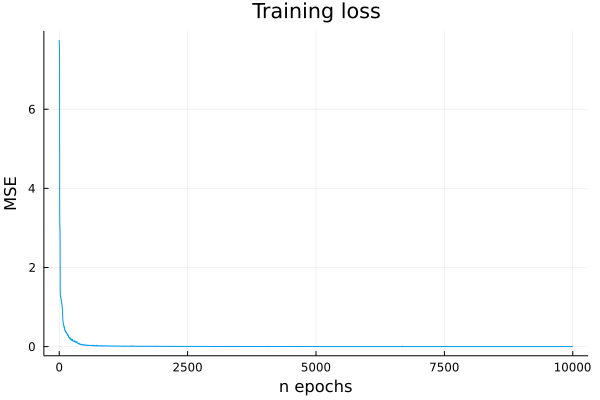

In [9]:
# plot the results
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

I define a function to compute $R^2$ for multidimensional target variables `r2score_multidim`, with similar functionality to <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html'>`sklearn.metrics.r2_score`</a>:
- `multioutput="rawvalues"` computes the $R^2$ score for each of the dimensions separately, returning a vector
- `multioutput="uniformaverage"` computes the $R^2$ score for each of the dimensions of the output separately, and averages the result uniformly
- (**TODO**) `multioutput="varianceweighted"` computes the $R^2$ score for each of the dimensions of the output separately, and then computes a weighted average with weights equal to the variance of each of the output dimensions. _This isn't needed just yet so I'll wait on implementing this_

In [10]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [11]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9996939413714198
r2 on test set: 0.9931772220304156


Recall that we can express the adjusted $R^2$, $\bar{R}^2$ in terms of our sample size $M$ and the dimensions of our input $p$:

$$ \bar{R}^2 = 1 - (1 - R^2) \frac{M - 1}{M - p - 1} $$

This extends our implementation of `r2score` and `r2score_multidim` easily.

In [12]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [13]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9996919393525902
adjustedr2 on test set: 0.9929946727870823


In [14]:
y_train_preds = m(x_train')';
y_test_preds = m(x_test')';

In [15]:
# mapes
function unscaled_mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    fit!(y_scaler, y_df[!, names(y_df)[i]])
    
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for $(names(y_df)[i]): ", unscaled_mape(temp_test_preds_original, temp_test_trues_original))
end

MAPE on test set for DE: 0.0076805720318151175
MAPE on test set for EMIT_X: 0.09239014204027832
MAPE on test set for EMIT_Y: 0.07146610159518865
MAPE on test set for RMS_S: 0.01871036243074089
MAPE on test set for RMS_X: 0.017727060554317848
MAPE on test set for RMS_Y: 0.026731360668583403


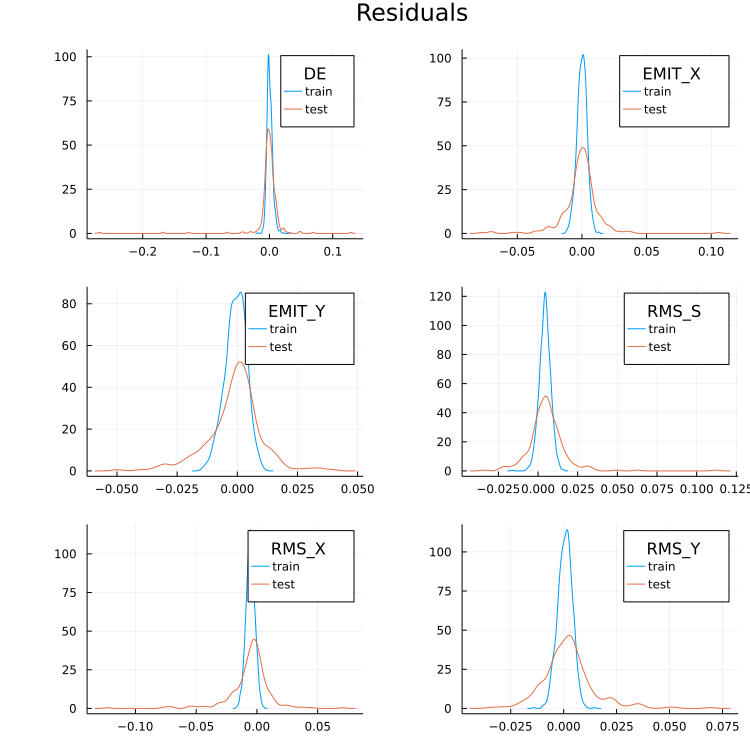

In [16]:
# plotting the residual distribution
l = @layout [grid(3,2)]
y_columns = names(y_df)
residuals_train = y_train - y_train_preds
residuals_test = y_test - y_test_preds

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

In [24]:
emit_x_train = y_train[:, 2];
emit_x_test = y_test[:, 2];
emit_y_train = y_train[:, 3];
emit_y_test = y_test[:, 3];

train_preds = m(x_train')'
test_preds = m(x_test')'

emit_x_train_preds = train_preds[:, 2];
emit_x_test_preds = test_preds[:, 2];
emit_y_train_preds = train_preds[:, 3];
emit_y_test_preds = test_preds[:, 3];

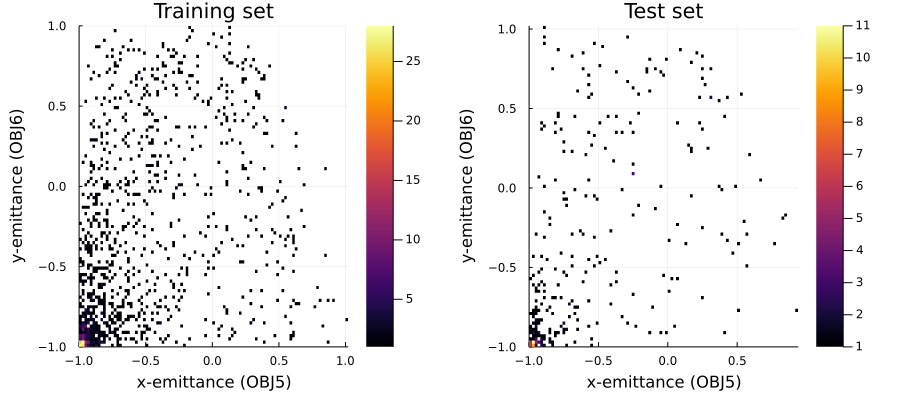

In [34]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    emit_x_train, emit_y_train;
    xlabel="x-emittance (OBJ5)", ylabel="y-emittance (OBJ6)", label="train", legend=true,
    title="Training set", bins=(100, 100)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    emit_x_test, emit_y_test;
    xlabel="x-emittance (OBJ5)", ylabel="y-emittance (OBJ6)", label="test", legend=true,
    title="Test set", bins=(100, 100)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

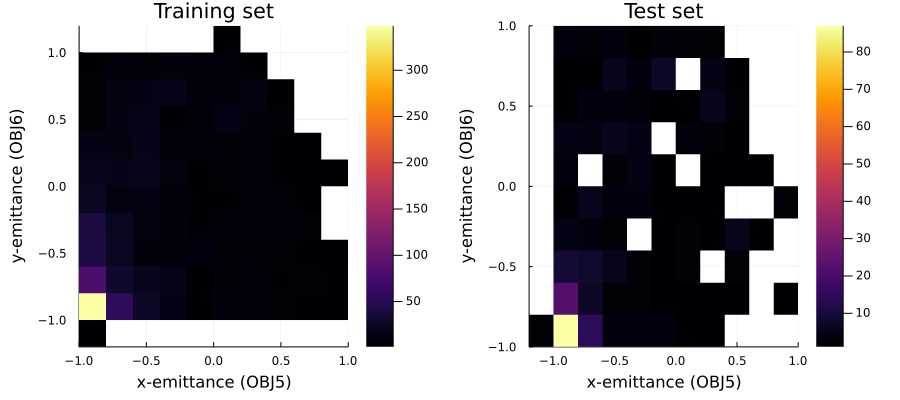

In [26]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    emit_x_train_preds, emit_y_train_preds;
    xlabel="x-emittance (OBJ5)", ylabel="y-emittance (OBJ6)", label="train", legend=true,
    title="Training set", bins=(15, 15)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    emit_x_test_preds, emit_y_test_preds;
    xlabel="x-emittance (OBJ5)", ylabel="y-emittance (OBJ6)", label="test", legend=true,
    title="Test set", bins=(15, 15)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

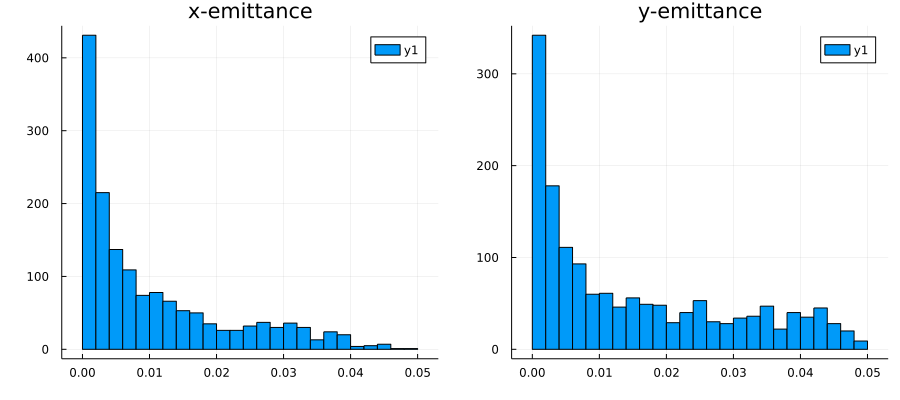

In [33]:
l = @layout [grid(1,2)]
subplots = []
x_plot = histogram(y_df[:, 2]; bins=40, title="x-emittance")
push!(subplots, x_plot)
y_plot = histogram(y_df[:, 3]; bins=40, title="y-emittance")
push!(subplots, y_plot)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

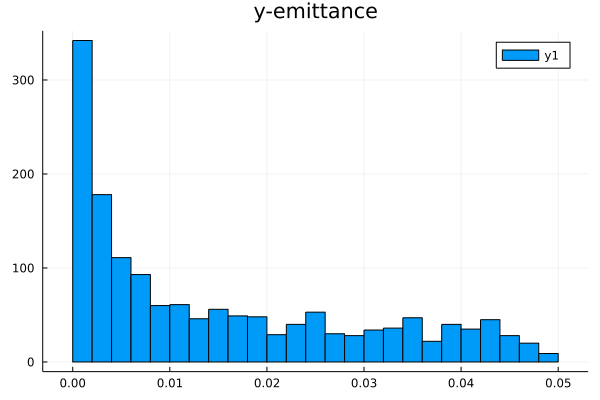